In [1]:
# ============================================================================
# CELL 1: INSTALLATION AND IMPORTS
# ============================================================================

# Uncomment and run this cell if packages are not installed
"""
!pip install transformers torch pandas scikit-learn matplotlib seaborn tqdm datasets accelerate
"""

# Core imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import warnings
import os
from pathlib import Path

# Transformers and ML imports
from transformers import (
    RobertaTokenizer,
    RobertaForSequenceClassification,
    get_linear_schedule_with_warmup,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from torch.optim import AdamW # Import AdamW from torch.optim

# Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

# Suppress warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Using device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name()}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

🚀 Using device: cuda
   GPU: Tesla T4
   Memory: 15.8 GB


In [2]:
# ============================================================================
# CELL 2: CONFIGURATION AND HYPERPARAMETERS
# ============================================================================

class Config:
    """
    Configuration class for hyperparameters and settings
    """
    # Model settings
    MODEL_NAME = 'roberta-base'  # or 'roberta-large'
    MAX_LENGTH = 128
    NUM_LABELS = 3  # Change this based on your classification task

    # Training settings
    BATCH_SIZE = 16  # Adjust based on GPU memory
    LEARNING_RATE = 2e-5
    NUM_EPOCHS = 3
    WARMUP_STEPS = 0.1
    WEIGHT_DECAY = 0.01

    # Data settings
    TEST_SIZE = 0.2
    VAL_SIZE = 0.1
    RANDOM_STATE = 42

    # Output settings
    OUTPUT_DIR = './roberta_model'
    SAVE_STEPS = 500
    EVAL_STEPS = 500
    LOGGING_STEPS = 100

config = Config()
print("📋 Configuration loaded successfully")

📋 Configuration loaded successfully


In [3]:
# ============================================================================
# CELL 3: DATA LOADING AND PREPROCESSING
# ============================================================================

def load_dataset(file_path, text_column='text', label_column='label'):
    """
    Load dataset from various file formats

    Args:
        file_path (str): Path to the dataset file
        text_column (str): Name of the text column
        label_column (str): Name of the label column

    Returns:
        pd.DataFrame: Loaded and preprocessed dataframe
    """
    print(f"📂 Loading dataset from: {file_path}")

    # Determine file type and load accordingly
    file_path = Path(file_path)

    if file_path.suffix.lower() == '.csv':
        df = pd.read_csv(file_path)
    elif file_path.suffix.lower() == '.json':
        df = pd.read_json(file_path, lines=True)
    elif file_path.suffix.lower() == '.xlsx':
        df = pd.read_excel(file_path)
    elif file_path.suffix.lower() == '.txt':
        # Assuming tab-separated format
        df = pd.read_csv(file_path, sep='\t', header=None, names=[label_column, text_column])
    else:
        raise ValueError(f"Unsupported file format: {file_path.suffix}")

    print(f"✅ Dataset loaded: {len(df):,} samples")
    print(f"   Columns: {list(df.columns)}")

    return df

def preprocess_data(df, text_column='text', label_column='label'):
    """
    Preprocess the dataset

    Args:
        df (pd.DataFrame): Input dataframe
        text_column (str): Name of the text column
        label_column (str): Name of the label column

    Returns:
        pd.DataFrame: Preprocessed dataframe
    """
    print("🔄 Preprocessing data...")

    # Remove missing values
    initial_size = len(df)
    df = df.dropna(subset=[text_column, label_column])
    print(f"   Removed {initial_size - len(df)} rows with missing values")

    # Clean text
    df[text_column] = df[text_column].astype(str)
    df[text_column] = df[text_column].str.strip()

    # Remove empty texts
    df = df[df[text_column].str.len() > 0]

    # Convert labels to integers if they're strings
    if df[label_column].dtype == 'object':
        unique_labels = sorted(df[label_column].unique())
        label_map = {label: idx for idx, label in enumerate(unique_labels)}
        df[label_column] = df[label_column].map(label_map)
        print(f"   Label mapping: {label_map}")

    # Ensure labels are integers
    df[label_column] = df[label_column].astype(int)

    # Update config with actual number of labels
    config.NUM_LABELS = len(df[label_column].unique())

    print(f"✅ Preprocessing complete: {len(df):,} samples")
    return df

def analyze_dataset(df, text_column='text', label_column='label'):
    """
    Analyze and visualize the dataset
    """
    print("\n📊 DATASET ANALYSIS")
    print("=" * 60)

    # Basic statistics
    print(f"Total samples: {len(df):,}")
    print(f"Text column: '{text_column}'")
    print(f"Label column: '{label_column}'")

    # Label distribution
    label_counts = df[label_column].value_counts().sort_index()
    print(f"\nLabel distribution:")
    for label, count in label_counts.items():
        percentage = (count / len(df)) * 100
        print(f"  Label {label}: {count:,} ({percentage:.1f}%)")

    # Text statistics
    text_lengths = df[text_column].str.len()
    word_counts = df[text_column].str.split().str.len()

    print(f"\nText statistics:")
    print(f"  Character length - Mean: {text_lengths.mean():.1f}, Median: {text_lengths.median():.1f}")
    print(f"  Word count - Mean: {word_counts.mean():.1f}, Median: {word_counts.median():.1f}")
    print(f"  Min length: {text_lengths.min()}, Max length: {text_lengths.max()}")

    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Label distribution
    label_counts.plot(kind='bar', ax=axes[0, 0], color='skyblue')
    axes[0, 0].set_title('Label Distribution')
    axes[0, 0].set_xlabel('Label')
    axes[0, 0].set_ylabel('Count')

    # Text length distribution
    axes[0, 1].hist(text_lengths, bins=50, alpha=0.7, color='lightcoral')
    axes[0, 1].set_title('Text Length Distribution (Characters)')
    axes[0, 1].set_xlabel('Length')
    axes[0, 1].set_ylabel('Frequency')

    # Word count distribution
    axes[1, 0].hist(word_counts, bins=50, alpha=0.7, color='lightgreen')
    axes[1, 0].set_title('Word Count Distribution')
    axes[1, 0].set_xlabel('Word Count')
    axes[1, 0].set_ylabel('Frequency')

    # Box plot of text lengths by label - FIXED VERSION
    # Create a temporary dataframe with text lengths for plotting
    temp_df = pd.DataFrame({
        'text_length': text_lengths,
        'label': df[label_column]
    })
    temp_df.boxplot(column='text_length', by='label', ax=axes[1, 1])
    axes[1, 1].set_title('Text Length by Label')
    axes[1, 1].set_xlabel('Label')
    axes[1, 1].set_ylabel('Text Length (Characters)')

    plt.tight_layout()
    plt.show()

    # Sample texts
    print(f"\n📄 Sample texts:")
    for label in sorted(df[label_column].unique()):
        sample_text = df[df[label_column] == label][text_column].iloc[0]
        preview = sample_text[:100] + "..." if len(sample_text) > 100 else sample_text
        print(f"  Label {label}: {preview}")

# Example usage:
# df = load_dataset('your_dataset.csv', text_column='text', label_column='label')
# df = preprocess_data(df, text_column='text', label_column='label')
# analyze_dataset(df, text_column='text', label_column='label')

In [4]:
# ============================================================================
# CELL 4: DATASET CLASS AND DATA LOADERS
# ============================================================================

class TextClassificationDataset(Dataset):
    """
    PyTorch Dataset for text classification with RoBERTa
    """

    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        # Tokenize using RoBERTa tokenizer
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

def create_data_loaders(df, text_column='text', label_column='label'):
    """
    Create train, validation, and test data loaders
    """
    print("🔄 Creating data loaders...")

    # Extract texts and labels
    texts = df[text_column].values
    labels = df[label_column].values

    # Split data
    X_train, X_temp, y_train, y_temp = train_test_split(
        texts, labels,
        test_size=config.TEST_SIZE + config.VAL_SIZE,
        random_state=config.RANDOM_STATE,
        stratify=labels
    )

    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp,
        test_size=config.TEST_SIZE / (config.TEST_SIZE + config.VAL_SIZE),
        random_state=config.RANDOM_STATE,
        stratify=y_temp
    )

    print(f"📊 Data split:")
    print(f"   Training: {len(X_train):,} samples")
    print(f"   Validation: {len(X_val):,} samples")
    print(f"   Testing: {len(X_test):,} samples")

    # Initialize tokenizer
    print(f"🔤 Loading RoBERta tokenizer: {config.MODEL_NAME}")
    tokenizer = RobertaTokenizer.from_pretrained(config.MODEL_NAME)

    # Create datasets
    train_dataset = TextClassificationDataset(X_train, y_train, tokenizer, config.MAX_LENGTH)
    val_dataset = TextClassificationDataset(X_val, y_val, tokenizer, config.MAX_LENGTH)
    test_dataset = TextClassificationDataset(X_test, y_test, tokenizer, config.MAX_LENGTH)

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=True,
        num_workers=2
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=False,
        num_workers=2
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=False,
        num_workers=2
    )

    print("✅ Data loaders created successfully")

    return train_loader, val_loader, test_loader, tokenizer



In [5]:
# ============================================================================
# CELL 5: MODEL INITIALIZATION
# ============================================================================

def initialize_model():
    """
    Initialize RoBERTa model for sequence classification
    """
    print(f"🤖 Loading RoBERTa model: {config.MODEL_NAME}")

    model = RobertaForSequenceClassification.from_pretrained(
        config.MODEL_NAME,
        num_labels=config.NUM_LABELS,
        output_attentions=False,
        output_hidden_states=False
    )

    # Move to device
    model = model.to(device)

    # Print model information
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"✅ Model loaded successfully")
    print(f"   Total parameters: {total_params:,}")
    print(f"   Trainable parameters: {trainable_params:,}")
    print(f"   Model size: {total_params * 4 / 1e6:.1f} MB")

    return model

In [6]:
# ============================================================================
# CELL 6: TRAINING FUNCTION
# ============================================================================

def train_model(model, train_loader, val_loader, tokenizer):
    """
    Train the RoBERTa model using HuggingFace Trainer
    """
    print("🚀 Starting model training...")

    # Create datasets for Trainer
    class TrainerDataset:
        def __init__(self, dataloader):
            self.data = []
            for batch in dataloader:
                for i in range(len(batch['input_ids'])):
                    self.data.append({
                        'input_ids': batch['input_ids'][i],
                        'attention_mask': batch['attention_mask'][i],
                        'labels': batch['labels'][i]
                    })

        def __len__(self):
            return len(self.data)

        def __getitem__(self, idx):
            return self.data[idx]

    train_dataset = TrainerDataset(train_loader)
    val_dataset = TrainerDataset(val_loader)

    # Training arguments
    training_args = TrainingArguments(
        output_dir=config.OUTPUT_DIR,
        num_train_epochs=config.NUM_EPOCHS,
        per_device_train_batch_size=config.BATCH_SIZE,
        per_device_eval_batch_size=config.BATCH_SIZE,
        warmup_steps=int(config.WARMUP_STEPS * len(train_loader) * config.NUM_EPOCHS),
        weight_decay=config.WEIGHT_DECAY,
        learning_rate=config.LEARNING_RATE,
        logging_dir=f'{config.OUTPUT_DIR}/logs',
        logging_steps=config.LOGGING_STEPS,
        eval_strategy='steps',
        eval_steps=config.EVAL_STEPS,
        save_steps=config.SAVE_STEPS,
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model='eval_accuracy',
        greater_is_better=True,
        remove_unused_columns=False,
        push_to_hub=False,
        report_to=None  # Disable wandb/tensorboard
    )

    # Define metrics
    def compute_metrics(eval_pred):
        predictions, labels = eval_pred
        predictions = np.argmax(predictions, axis=1)

        precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
        accuracy = accuracy_score(labels, predictions)

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }

    # Initialize trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    # Train the model
    print("🔄 Training in progress...")
    train_result = trainer.train()

    # Save the model
    trainer.save_model()
    tokenizer.save_pretrained(config.OUTPUT_DIR)

    print("✅ Training completed!")
    print(f"   Training loss: {train_result.training_loss:.4f}")
    print(f"   Model saved to: {config.OUTPUT_DIR}")

    return trainer, train_result

In [7]:
# ============================================================================
# CELL 7: EVALUATION FUNCTIONS
# ============================================================================

def evaluate_model(model, test_loader, class_names=None):
    """
    Comprehensive model evaluation
    """
    print("🔍 Evaluating model on test set...")

    model.eval()
    predictions = []
    true_labels = []
    probabilities = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            # Get predictions and probabilities
            batch_predictions = torch.argmax(logits, dim=1)
            batch_probabilities = torch.softmax(logits, dim=1)

            predictions.extend(batch_predictions.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            probabilities.extend(batch_probabilities.cpu().numpy())

    # Convert to numpy arrays
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    probabilities = np.array(probabilities)

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted')

    # Print results
    print(f"\n📈 EVALUATION RESULTS")
    print("=" * 50)
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")

    # Detailed classification report
    if class_names is None:
        class_names = [f'Class {i}' for i in range(config.NUM_LABELS)]

    print(f"\n📋 Detailed Classification Report:")
    print(classification_report(true_labels, predictions, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predictions)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # ROC Curve (for binary classification)
    if config.NUM_LABELS == 2:
        auc = roc_auc_score(true_labels, probabilities[:, 1])
        fpr, tpr, _ = roc_curve(true_labels, probabilities[:, 1])

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.3f})')
        plt.plot([0, 1], [0, 1], 'k--', label='Random')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.show()

        print(f"AUC Score: {auc:.4f}")

    # Class-wise metrics
    precision_class, recall_class, f1_class, support = precision_recall_fscore_support(
        true_labels, predictions, average=None
    )

    print(f"\n📊 Class-wise Performance:")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}:")
        print(f"  Precision: {precision_class[i]:.4f}")
        print(f"  Recall:    {recall_class[i]:.4f}")
        print(f"  F1-Score:  {f1_class[i]:.4f}")
        print(f"  Support:   {support[i]}")

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': predictions,
        'probabilities': probabilities,
        'confusion_matrix': cm
    }


In [8]:
# ============================================================================
# CELL 8: PREDICTION FUNCTIONS
# ============================================================================

def predict_text(model, tokenizer, text, return_probabilities=True):
    """
    Predict class for a single text
    """
    model.eval()

    # Tokenize
    encoding = tokenizer(
        text,
        add_special_tokens=True,
        max_length=config.MAX_LENGTH,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    # Move to device
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Get probabilities and prediction
        probabilities = torch.softmax(logits, dim=-1)
        prediction = torch.argmax(logits, dim=-1).item()
        confidence = torch.max(probabilities).item()

    result = {
        'text': text,
        'prediction': prediction,
        'confidence': confidence
    }

    if return_probabilities:
        result['probabilities'] = probabilities.cpu().numpy()[0]

    return result

def batch_predict(model, tokenizer, texts):
    """
    Predict classes for multiple texts
    """
    results = []

    print(f"🔮 Making predictions for {len(texts)} texts...")
    for text in tqdm(texts, desc='Predicting'):
        result = predict_text(model, tokenizer, text)
        results.append(result)

    return results

In [9]:
# ============================================================================
# CELL 9: MAIN PIPELINE
# ============================================================================

def run_complete_pipeline(dataset_path, text_column='text', label_column='label', class_names=None):
    """
    Complete end-to-end pipeline
    """
    print("🎯 ROBERTA TRANSFER LEARNING PIPELINE")
    print("=" * 60)

    try:
        # Step 1: Load and preprocess data
        df = load_dataset(dataset_path, text_column, label_column)
        df = preprocess_data(df, text_column, label_column)
        analyze_dataset(df, text_column, label_column)

        # Step 2: Create data loaders
        train_loader, val_loader, test_loader, tokenizer = create_data_loaders(df, text_column, label_column)

        # Step 3: Initialize model
        model = initialize_model()

        # Step 4: Train model
        trainer, train_result = train_model(model, train_loader, val_loader, tokenizer)

        # Step 5: Evaluate model
        results = evaluate_model(model, test_loader, class_names)

        # Step 6: Test predictions on sample texts
        print(f"\n🧪 SAMPLE PREDICTIONS")
        print("=" * 40)

        # Get sample texts from test set
        sample_texts = df.sample(5)[text_column].tolist()
        sample_predictions = batch_predict(model, tokenizer, sample_texts)

        for pred in sample_predictions:
            print(f"\nText: {pred['text'][:100]}...")
            print(f"Prediction: {pred['prediction']}")
            print(f"Confidence: {pred['confidence']:.4f}")
            if 'probabilities' in pred:
                for i, prob in enumerate(pred['probabilities']):
                    class_name = class_names[i] if class_names else f'Class {i}'
                    print(f"  {class_name}: {prob:.4f}")

        print(f"\n✅ Pipeline completed successfully!")
        print(f"📁 Model saved to: {config.OUTPUT_DIR}")

        return model, tokenizer, results

    except Exception as e:
        print(f"❌ Error in pipeline: {str(e)}")
        raise e


🎯 ROBERTA TRANSFER LEARNING PIPELINE
📂 Loading dataset from: /content/trainDataset.csv
✅ Dataset loaded: 2,217 samples
   Columns: ['label', 'text']
🔄 Preprocessing data...
   Removed 0 rows with missing values
   Label mapping: {'normal': 0, 'promo': 1, 'smish': 2}
✅ Preprocessing complete: 2,217 samples

📊 DATASET ANALYSIS
Total samples: 2,217
Text column: 'text'
Label column: 'label'

Label distribution:
  Label 0: 727 (32.8%)
  Label 1: 733 (33.1%)
  Label 2: 757 (34.1%)

Text statistics:
  Character length - Mean: 76.1, Median: 67.0
  Word count - Mean: 10.7, Median: 8.0
  Min length: 4, Max length: 650


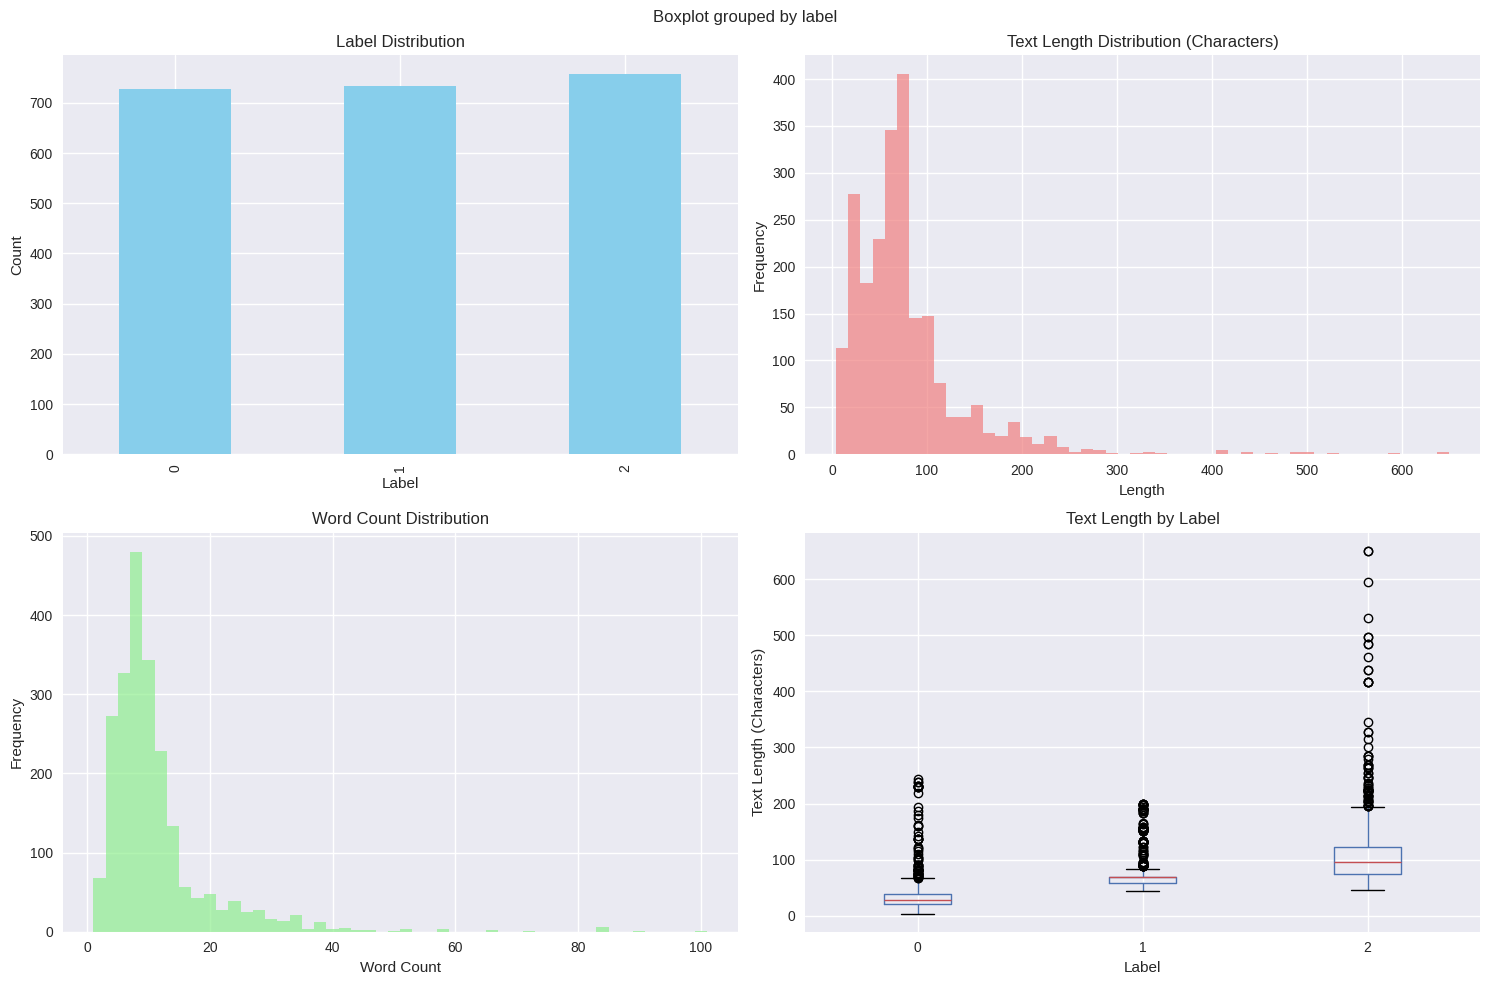


📄 Sample texts:
  Label 0: সব ঠিক হয়ে যাবে, সাহস রেখো।
  Label 1: বিশেষ অফার: সব বাচ্চাদের পোশাকে ২০% ডিসকাউন্ট।
  Label 2: আপনার একাউন্ট হ্যাক হতে পারে। দ্রুত ৩০০০ টাকা পাঠান এই নাম্বারে: ০১৭৮৯৬৫৪৩২।
🔄 Creating data loaders...
📊 Data split:
   Training: 1,551 samples
   Validation: 222 samples
   Testing: 444 samples
🔤 Loading RoBERta tokenizer: roberta-base


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

✅ Data loaders created successfully
🤖 Loading RoBERTa model: roberta-base


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded successfully
   Total parameters: 124,647,939
   Trainable parameters: 124,647,939
   Model size: 498.6 MB
🚀 Starting model training...
🔄 Training in progress...


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: alvijr35 (alvijr35-american-international-university-bangladesh) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss


✅ Training completed!
   Training loss: 0.4075
   Model saved to: ./roberta_model
🔍 Evaluating model on test set...


Evaluating:   0%|          | 0/28 [00:00<?, ?it/s]


📈 EVALUATION RESULTS
Accuracy:  0.9482
Precision: 0.9507
Recall:    0.9482
F1-Score:  0.9485

📋 Detailed Classification Report:
              precision    recall  f1-score   support

      normal       0.97      0.95      0.96       145
       promo       0.99      0.92      0.95       147
       smish       0.90      0.97      0.93       152

    accuracy                           0.95       444
   macro avg       0.95      0.95      0.95       444
weighted avg       0.95      0.95      0.95       444



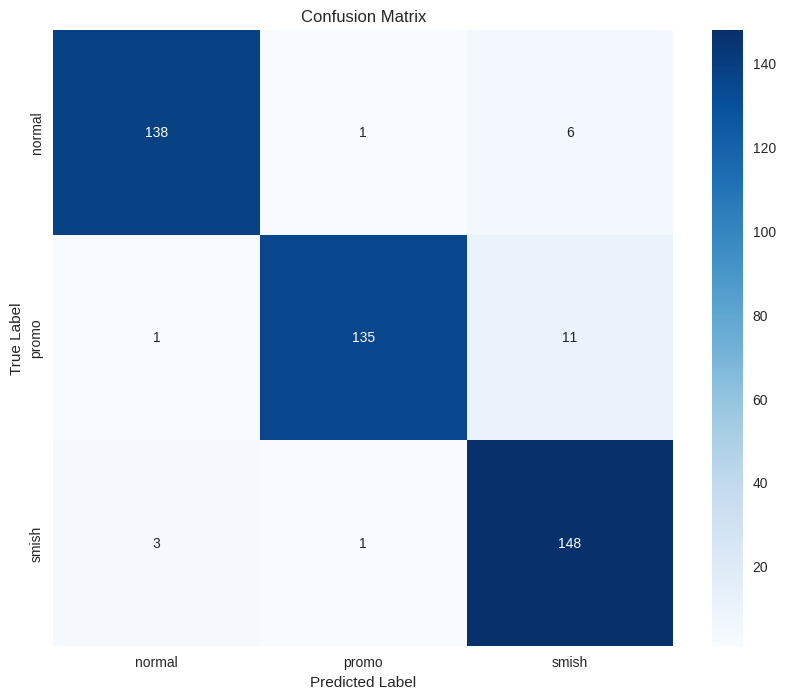


📊 Class-wise Performance:
normal:
  Precision: 0.9718
  Recall:    0.9517
  F1-Score:  0.9617
  Support:   145
promo:
  Precision: 0.9854
  Recall:    0.9184
  F1-Score:  0.9507
  Support:   147
smish:
  Precision: 0.8970
  Recall:    0.9737
  F1-Score:  0.9338
  Support:   152

🧪 SAMPLE PREDICTIONS
🔮 Making predictions for 5 texts...


Predicting:   0%|          | 0/5 [00:00<?, ?it/s]


Text: আপনার একাউন্টে সমস্যা হয়েছে। দ্রুত এই নাম্বারে যোগাযোগ করুন ০১৭২৮৩৭৫৮৪৩।...
Prediction: 2
Confidence: 0.9165
  normal: 0.0110
  promo: 0.0725
  smish: 0.9165

Text: সুবর্ণ সন্ধ্যা!...
Prediction: 0
Confidence: 0.9966
  normal: 0.9966
  promo: 0.0017
  smish: 0.0017

Text: ফার্নিচারে মেগা সেল! সব পণ্যে ১৫-৩০% ছাড়। আজই ভিজিট করুন।...
Prediction: 1
Confidence: 0.9944
  normal: 0.0024
  promo: 0.9944
  smish: 0.0032

Text: ক্যাসিনোতে বাজি ধরুন এবং ৭ দিনের জন্য একটি ফ্রি ট্রিপ জিতুন! এখনই শুরু করুন: ebayisapidlld.altervist...
Prediction: 2
Confidence: 0.9827
  normal: 0.0060
  promo: 0.0114
  smish: 0.9827

Text: ফ্ল্যাশ বিক্রয়! পরবর্তী 24 ঘন্টার জন্য Daraz-এ 70% পর্যন্ত ছাড় পান। আপনার ডিসকাউন্ট দাবি করতে এখান...
Prediction: 2
Confidence: 0.9870
  normal: 0.0028
  promo: 0.0102
  smish: 0.9870

✅ Pipeline completed successfully!
📁 Model saved to: ./roberta_model
🔮 Making predictions for 3 texts...


Predicting:   0%|          | 0/3 [00:00<?, ?it/s]

Text: This is a great product!
Prediction: 0 (confidence: 0.908)
Text: I hate this service.
Prediction: 0 (confidence: 0.712)
Text: Average quality, nothing special.
Prediction: 0 (confidence: 0.642)


NameError: name 'create_custom_test_loader' is not defined

In [10]:
# ============================================================================
# CELL 10: USAGE EXAMPLES AND TESTING
# ============================================================================

# EXAMPLE 1: Load your dataset and run the complete pipeline

# For a CSV file with columns 'text' and 'label'
# Uncomment and modify the following lines for your dataset:

model, tokenizer, results = run_complete_pipeline(
    dataset_path='/content/trainDataset.csv',  # Your training data
    text_column='text',
    label_column='label',
    class_names=['normal', 'promo', 'smish']
)


# EXAMPLE 2: Load saved model and make predictions

from transformers import RobertaTokenizer, RobertaForSequenceClassification

# Load saved model
model = RobertaForSequenceClassification.from_pretrained('./roberta_model')
tokenizer = RobertaTokenizer.from_pretrained('./roberta_model')
model.to(device)

# Make predictions
test_texts = [
    "This is a great product!",
    "I hate this service.",
    "Average quality, nothing special."
]

predictions = batch_predict(model, tokenizer, test_texts)
for pred in predictions:
    print(f"Text: {pred['text']}")
    print(f"Prediction: {pred['prediction']} (confidence: {pred['confidence']:.3f})")


# EXAMPLE 3: Custom evaluation

# If you want to evaluate on a different test set
custom_test_df = pd.read_csv('/content/testDataset.csv')
custom_test_loader = create_custom_test_loader(custom_test_df, tokenizer, text_column='text', label_column='label')
custom_results = evaluate_model(model, custom_test_loader)


print("🎉 RoBERTa Transfer Learning Pipeline Ready!")
print("\n📚 Instructions:")
print("1. Replace 'your_dataset.csv' with your actual dataset path")
print("2. Update text_column and label_column names if different")
print("3. Adjust Config class parameters for your specific needs")
print("4. Run the pipeline: model, tokenizer, results = run_complete_pipeline('your_data.csv')")
print("\n⚙️  Configuration can be modified in the Config class above")
print("🔧 Adjust batch_size, learning_rate, epochs based on your dataset size and compute resources")